In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle

df_eddies = pd.read_pickle('/srv/scratch/z5297792/Chapter2/SEACOFS_26yr_Eddy_Dataset/Eddy_Data/df_eddies_processed_1462_10650.pkl')

with open('/srv/scratch/z5297792/Chapter2/SEACOFS_26yr_Eddy_Dataset/Eddy_Data/Vertical_Eddy_Dataset/dic_vert_eddies.pkl', 'rb') as f:
    dic_eddies_vert = pickle.load(f)

df_tilt_data = pd.read_pickle("/srv/scratch/z5297792/Chapter2/SEACOFS_26yr_Eddy_Dataset/Eddy_Data/Vertical_Eddy_Dataset/df_tilt_data_no_processing.pkl")
df_eddies = df_eddies.merge(
    df_tilt_data[['Eddy', 'Day', 'TiltDis', 'TiltDir']],
    how='left',
    left_on=['Eddy', 'Day'],
    right_on=['Eddy', 'Day']
)

# import sys
# sys.path.append("/home/z5297792/UNSW-MRes/MRes/modules") 
# from utils import smooth


In [2]:
import netCDF4 as nc
from scipy.interpolate import griddata
import netCDF4 as nc
from scipy.interpolate import RegularGridInterpolator

fname = f'/srv/scratch/z3533156/26year_BRAN2020/outer_avg_01461.nc'
dataset = nc.Dataset(fname)
lon_rho = np.transpose(dataset.variables['lon_rho'], axes=(1, 0))
lat_rho = np.transpose(dataset.variables['lat_rho'], axes=(1, 0))
mask_rho = np.transpose(dataset.variables['mask_rho'], axes=(1, 0))
h =  np.transpose(dataset.variables['h'], axes=(1, 0))
angle = dataset.variables['angle'][0, 0]
z_r = np.load('/srv/scratch/z5297792/z_r.npy')
z_r = np.transpose(z_r, (1, 2, 0))[150, 150, :]
def distance(lat1, lon1, lat2, lon2):
    EARTH_RADIUS = 6357
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    dlat, dlon = lat2 - lat1, lon2 - lon1
    a = np.sin(dlat/2)**2 + np.cos(lat1)*np.cos(lat2)*np.sin(dlon/2)**2
    return EARTH_RADIUS * 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
j_mid = lon_rho.shape[1] // 2
i_mid = lon_rho.shape[0] // 2
dx = distance(lat_rho[:-1, j_mid], lon_rho[:-1, j_mid],
              lat_rho[1:, j_mid], lon_rho[1:, j_mid])
dy = distance(lat_rho[i_mid, :-1], lon_rho[i_mid, :-1],
              lat_rho[i_mid, 1:], lon_rho[i_mid, 1:])
x_grid = np.insert(np.cumsum(dx), 0, 0)
y_grid = np.insert(np.cumsum(dy), 0, 0)
X_grid, Y_grid = np.meshgrid(x_grid, y_grid, indexing='ij')

levels_lat = [-40, -35, -30, -25]
levels_lon = [150, 155, 160]


In [3]:
kmday_to_ms = 1000 / 86400

# --- top-centre displacements + propagation speed ---
df_eddies['dx_top'] = df_eddies.groupby('Eddy')['xc'].diff()
df_eddies['dy_top'] = df_eddies.groupby('Eddy')['yc'].diff()
df_eddies['EddyProp'] = np.hypot(df_eddies['dx_top'], df_eddies['dy_top']) * kmday_to_ms

# --- bottom-centre positions (single pass) ---
df_idx = df_eddies.set_index(['Eddy', 'Day'])

x_btm, y_btm = [], []
for eddy, dic in dic_eddies_vert.items():
    eddy_id = int(eddy[4:])  # "Eddy####" -> ####
    for day, df in dic.items():
        day_id = int(day[3:])  # "Day##" -> ##
        if len(df):
            d = df[df.Depth.abs() < 1000]
            row = (d.iloc[-1] if len(d) else df.iloc[-1])
            x_btm.append(row.x)
            y_btm.append(row.y)
        else:
            row = df_idx.loc[(eddy_id, day_id)]
            x_btm.append(row.xc)
            y_btm.append(row.yc)

df_eddies['x_btm'] = x_btm
df_eddies['y_btm'] = y_btm

# --- bottom-centre displacements + propagation speed ---
df_eddies['dx_btm'] = df_eddies.groupby('Eddy')['x_btm'].diff()
df_eddies['dy_btm'] = df_eddies.groupby('Eddy')['y_btm'].diff()
df_eddies['btm_prop'] = np.hypot(df_eddies['dx_btm'], df_eddies['dy_btm']) * kmday_to_ms

# # --- separation and separation rate ---
# df_eddies['sep_km'] = np.hypot(df_eddies['x_btm'] - df_eddies['xc'],
#                                df_eddies['y_btm'] - df_eddies['yc'])
# df_eddies['sep_rate_ms'] = df_eddies.groupby('Eddy')['sep_km'].diff() * kmday_to_ms

# # --- optional: vector difference between top and bottom (m/s) ---
# df_eddies['top_btm_diff'] = np.hypot(df_eddies['dx_btm'] - df_eddies['dx_top'],
#                                      df_eddies['dy_btm'] - df_eddies['dy_top']) * kmday_to_ms



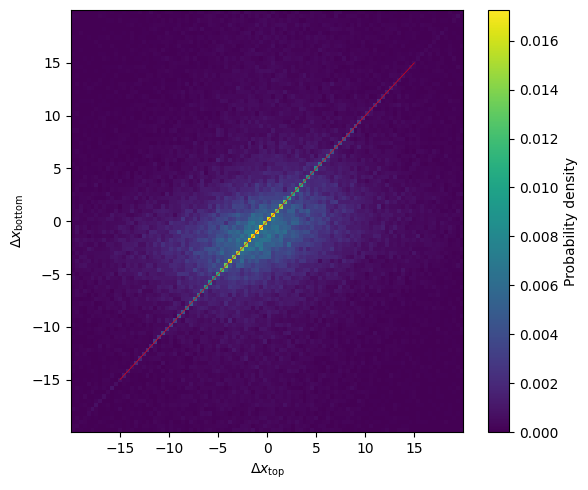

In [4]:
x = df_eddies.dx_top
y = df_eddies.dx_btm

mask = (np.abs(x) < 20) & (np.abs(y) < 20)

plt.figure(figsize=(6,5))
plt.hist2d(x[mask], y[mask], bins=100, density=True)
plt.colorbar(label='Probability density')
plt.xlabel(r'$\Delta x_{\mathrm{top}}$')
plt.ylabel(r'$\Delta x_{\mathrm{bottom}}$')

plt.plot([-15,15], [-15,15], color='r', lw=.4)

plt.tight_layout()


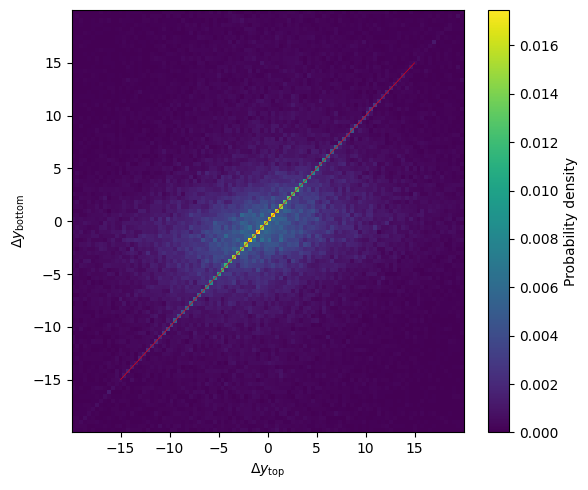

In [5]:
x = df_eddies.dy_top
y = df_eddies.dy_btm

mask = (np.abs(x) < 20) & (np.abs(y) < 20)

plt.figure(figsize=(6,5))
plt.hist2d(x[mask], y[mask], bins=100, density=True)
plt.colorbar(label='Probability density')
plt.xlabel(r'$\Delta y_{\mathrm{top}}$')
plt.ylabel(r'$\Delta y_{\mathrm{bottom}}$')

plt.plot([-15,15], [-15,15], color='r', lw=.4)

plt.tight_layout()


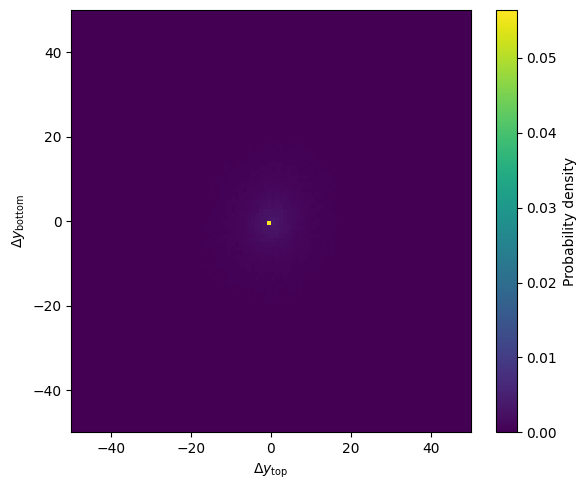

In [6]:
x = df_eddies.dx_top - df_eddies.dx_btm
y = df_eddies.dy_top - df_eddies.dy_btm

mask = (np.abs(x) < 50) & (np.abs(y) < 50)

plt.figure(figsize=(6,5))
plt.hist2d(x[mask], y[mask], bins=100, density=True)
plt.colorbar(label='Probability density')
plt.xlabel(r'$\Delta y_{\mathrm{top}}$')
plt.ylabel(r'$\Delta y_{\mathrm{bottom}}$')

# plt.plot([-15,15], [-15,15], color='r', lw=.4)

plt.tight_layout()



In [10]:
x.max(), y.max()

(np.float64(223.25306453623296), np.float64(190.67326960738345))

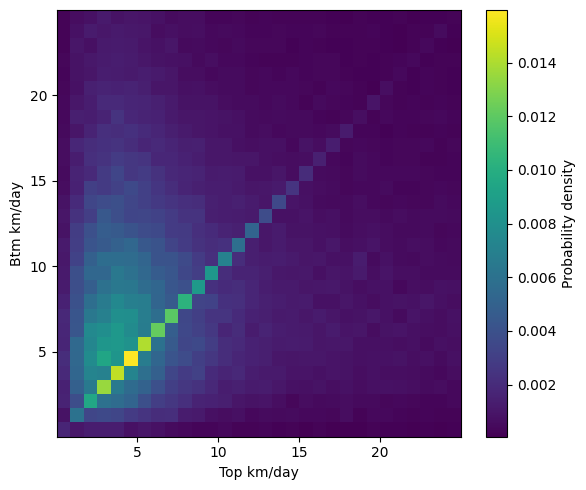

In [15]:
x = np.hypot(df_eddies.dx_btm,  df_eddies.dy_btm)
y = np.hypot(df_eddies.dx_top,  df_eddies.dy_top)

mask = (np.abs(x) < 25) & (np.abs(y) < 25)

plt.figure(figsize=(6,5))
plt.hist2d(x[mask], y[mask], bins=30, density=True)
plt.colorbar(label='Probability density')
plt.xlabel(r'Top km/day')
plt.ylabel(r'Btm km/day')

# plt.plot([-15,15], [-15,15], color='r', lw=.4)

plt.tight_layout()



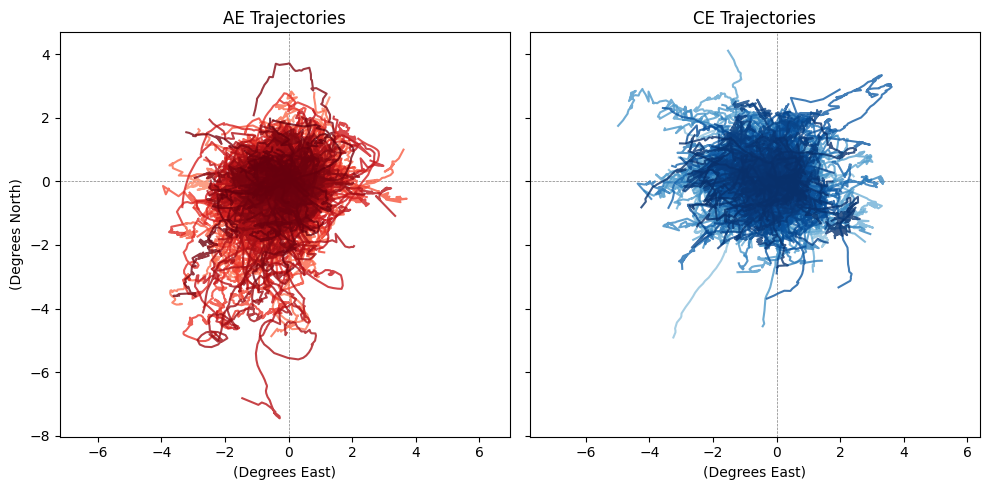

In [7]:
import matplotlib.cm as cm

fig, axs = plt.subplots(1, 2, figsize=(10,5), sharey=True)
for ax in axs:
    ax.axhline(y=0, color='k', ls='--', alpha=.5, lw=.5)
    ax.axvline(x=0, color='k', ls='--', alpha=.5, lw=.5)
# separate groups
ae = [e for e in df_eddies.Eddy.unique() if df_eddies[df_eddies.Eddy==e].iloc[0].Cyc == 'AE']
ce = [e for e in df_eddies.Eddy.unique() if df_eddies[df_eddies.Eddy==e].iloc[0].Cyc != 'AE']

# colour ranges
colors_ae = cm.Reds(np.linspace(0.4, 1, len(ae)))
colors_ce = cm.Blues(np.linspace(0.4, 1, len(ce)))

for c, eddy in zip(colors_ae, ae):
    df = df_eddies[df_eddies.Eddy==eddy]
    axs[0].plot(df.Lon-df.iloc[0].Lon, df.Lat-df.iloc[0].Lat, color=c, alpha=0.8)

for c, eddy in zip(colors_ce, ce):
    df = df_eddies[df_eddies.Eddy==eddy]
    axs[1].plot(df.Lon-df.iloc[0].Lon, df.Lat-df.iloc[0].Lat, color=c, alpha=0.8)

axs[0].axis('equal'); axs[1].axis('equal')
axs[0].set_title('AE Trajectories')
axs[1].set_title('CE Trajectories')
axs[0].set_xlabel('(Degrees East)'); axs[0].set_ylabel('(Degrees North)')
axs[1].set_xlabel('(Degrees East)')

plt.tight_layout()
plt.show()


AE Below 0: 52.01 %
AE Above 0: 45.56 %
CE Below 0: 53.20 %
CE Above 0: 44.22 %


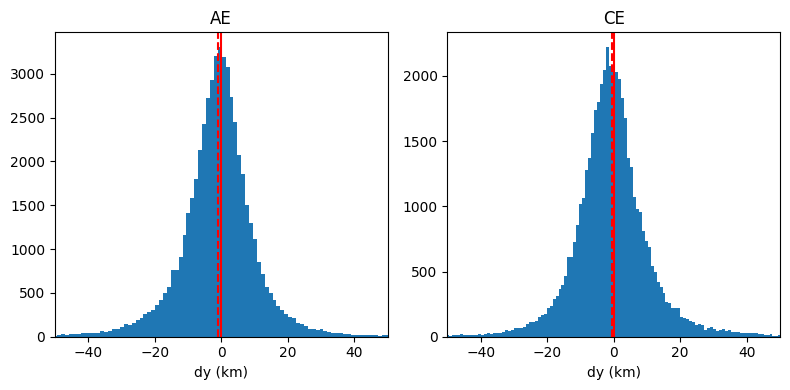

In [8]:
df_AE = df_eddies[df_eddies.Cyc=='AE'].copy()
df_CE = df_eddies[df_eddies.Cyc=='CE'].copy()

fig, axs = plt.subplots(1, 2, figsize=(8,4))

axs[0].hist(df_AE.dy_top, bins=300)
axs[0].set_xlim(-50, 50)
axs[0].axvline(0, color='r') 
axs[0].axvline(df_AE.dy_top.mean(), color='r', ls='--') 
axs[0].set_title('AE'); axs[0].set_xlabel('dy (km)')
print(f'AE Below 0: {(df_AE.dy_top<=0).mean()*100:.2f} %')
print(f'AE Above 0: {(df_AE.dy_top>=0).mean()*100:.2f} %')

axs[1].hist(df_CE.dy_top, bins=300)
axs[1].set_xlim(-50, 50)
axs[1].axvline(0, color='r') 
axs[1].axvline(df_CE.dy_top.mean(), color='r', ls='--')
axs[1].set_title('CE'); axs[1].set_xlabel('dy (km)')
print(f'CE Below 0: {(df_CE.dy_top<=0).mean()*100:.2f} %')
print(f'CE Above 0: {(df_CE.dy_top>=0).mean()*100:.2f} %')

plt.tight_layout()


In [9]:
df_eddies['prop_mag'] = np.hypot(df_eddies.dx_top, df_eddies.dy_top)
df_eddies['prop_bearing'] = (np.degrees(np.arctan2(df_eddies.dx_top, df_eddies.dy_top)) + 360) % 360

df_eddies['prop_mag_btm'] = np.hypot(df_eddies.dx_btm, df_eddies.dy_btm)
df_eddies['prop_bearing_btm'] = (np.degrees(np.arctan2(df_eddies.dx_btm, df_eddies.dy_btm)) + 360) % 360

df_eddies['prop_mag_diff'] = np.hypot(df_eddies.dx_top - df_eddies.dx_btm, df_eddies.dy_top - df_eddies.dy_btm)
df_eddies['prop_bearing_diff'] = (np.degrees(np.arctan2(df_eddies.dx_top - df_eddies.dx_btm, df_eddies.dy_top - df_eddies.dy_btm)) + 360) % 360



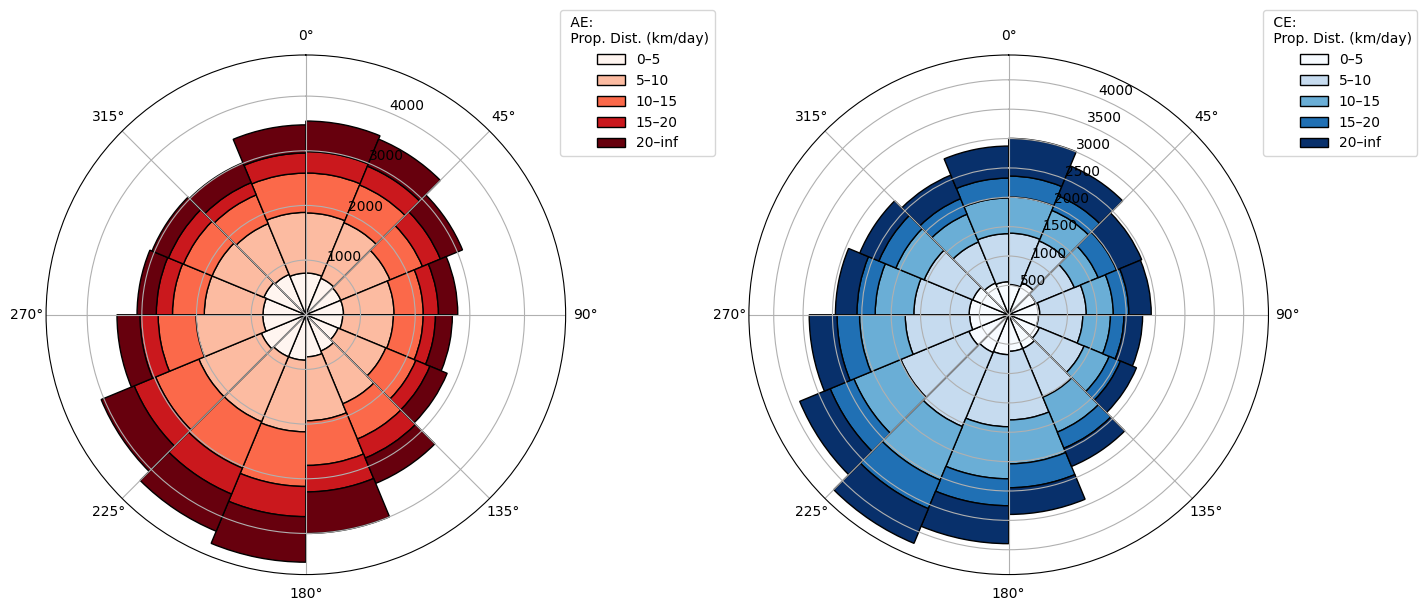

In [10]:
df_AE = df_eddies[df_eddies.Cyc=='AE'].copy()
df_CE = df_eddies[df_eddies.Cyc=='CE'].copy()

# Define your bins once
dir_bins = np.linspace(0, 360, 17)      # 16 sectors
mag_bins = [0, 5, 10, 15, 20, np.inf]     # your strength categories
angles = np.deg2rad((dir_bins[:-1] + dir_bins[1:]) / 2)
width = 2 * np.pi / (len(dir_bins)-1)
colors1 = plt.cm.Reds(np.linspace(0, 1, len(mag_bins)-1))
colors2 = plt.cm.Blues(np.linspace(0, 1, len(mag_bins)-1))

# Create figure + axes
fig, axs = plt.subplots(1, 2,
                        subplot_kw={'projection': 'polar'},
                        figsize=(14, 6),
                        constrained_layout=True)

for a, (ax, (df, title)) in enumerate(zip(axs, [(df_AE, 'AE'), (df_CE, 'CE')])):
    # df = df[df.Age >= 12*7].copy()
    directions = df.prop_bearing
    magnitudes = df.prop_mag

    # Digitise
    dir_idx = np.digitize(directions, dir_bins) - 1
    mag_idx = np.digitize(magnitudes, mag_bins) - 1

    # Count per bin
    counts = np.zeros((len(mag_bins)-1, len(dir_bins)-1))
    for d_i, m_i in zip(dir_idx, mag_idx):
        if 0 <= d_i < counts.shape[1] and 0 <= m_i < counts.shape[0]:
            counts[m_i, d_i] += 1

    # Plot stacked bars
    bottom = np.zeros(counts.shape[1])
    for i in range(counts.shape[0]):
        ax.bar(angles,
               counts[i],
               width,
               bottom=bottom,
               color=colors1[i] if a==0 else colors2[i],
               edgecolor='k',
               label=f'{mag_bins[i]:g}–{mag_bins[i+1]:g}')
        bottom += counts[i]

    ax.set_theta_zero_location('N')
    ax.set_theta_direction(-1)
    # ax.set_title(f'{title}')
    ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1), title=f' {title}: \n Prop. Dist. (km/day)')

# One legend for both
plt.show()



Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.


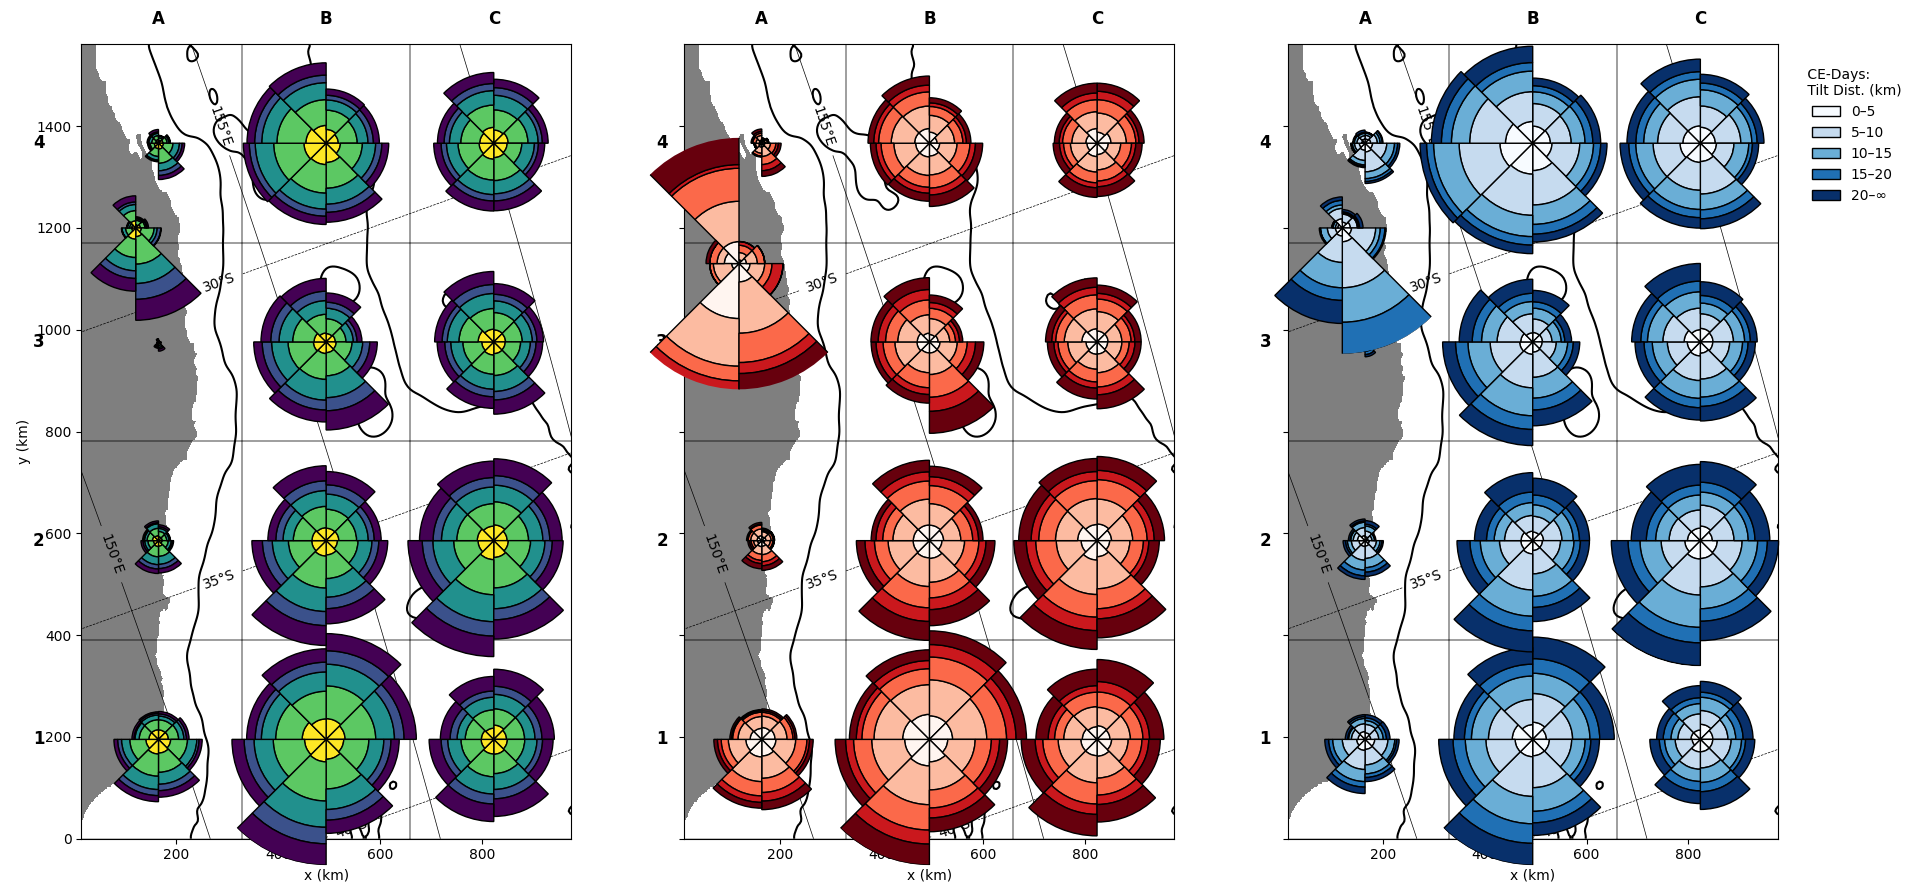

In [11]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

ncols, nrows = 3, 4
x_edges = np.linspace(X_grid.min(), X_grid.max(), ncols+1)
y_edges = np.linspace(Y_grid.min(), Y_grid.max(), nrows+1)
cell_w = (X_grid.max() - X_grid.min())/ncols
cell_h = (Y_grid.max() - Y_grid.min())/nrows

dir_bins = np.linspace(0, 360, 9)
mag_bins = [0, 5, 10, 15, 20, np.inf] 
n_dirs = len(dir_bins) - 1
angles = np.deg2rad((dir_bins[:-1] + dir_bins[1:]) / 2)
width = 2*np.pi / n_dirs
colors_cmps = [plt.cm.viridis_r(np.linspace(0, 1, len(mag_bins)-1)),
               plt.cm.Reds(np.linspace(0, 1, len(mag_bins)-1)),
               plt.cm.Blues(np.linspace(0, 1, len(mag_bins)-1))]

def windrose_counts(directions, magnitudes):
    if len(directions) == 0: return None
    d = np.digitize(np.mod(directions, 360), dir_bins) - 1
    m = np.digitize(magnitudes, mag_bins) - 1
    c = np.zeros((len(mag_bins)-1, n_dirs))
    for di, mi in zip(d, m):
        if 0 <= di < n_dirs and 0 <= mi < len(mag_bins)-1:
            c[mi, di] += 1
    return c

def add_windrose(ax, x0, y0, c, rmax, colors, frac=0.45, tick_flag=False, title=''):
    if c is None: return
    s = frac * min(cell_w, cell_h)
    iax = ax.inset_axes([x0 - s/2, y0 - s/2, s, s], transform=ax.transData, projection='polar')
    bottom = np.zeros(n_dirs)
    for i in range(len(mag_bins)-1):
        hi = "∞" if np.isinf(mag_bins[i+1]) else f"{mag_bins[i+1]:g}"
        label = f"{mag_bins[i]:g}–{hi}"
        iax.bar(angles, c[i], width, bottom=bottom, edgecolor='k', color=colors[i], label=label)
        bottom += c[i]
    iax.set_theta_zero_location('N')
    iax.set_theta_direction(-1)
    iax.set_rlim(0, rmax)
    if tick_flag:
        iax.legend(title=title, loc='upper right', frameon=False, fontsize=10, title_fontsize=10, bbox_to_anchor=(1.35, .85))
    iax.set_xticks([]); iax.set_yticks([]); iax.set_frame_on(False)
    return iax

# precompute counts per cell + global rmax
def cell_counts(df):
    out, rmax = {}, 0.0
    for i in range(ncols):
        for j in range(nrows):
            x0, x1 = x_edges[i], x_edges[i+1]
            y0, y1 = y_edges[j], y_edges[j+1]
            sub = df[(df.xc >= x0) & (df.xc < x1) & (df.yc >= y0) & (df.yc < y1)]
            # sub = sub[sub.Age >= 12*7].copy()
            d = np.asarray((sub.prop_bearing.dropna().values - 20) % 360, float) 
            m = np.asarray(sub.prop_mag.dropna().values, float)
            n = min(len(d), len(m))
            c = windrose_counts(d[:n], m[:n])
            out[(i,j)] = c
            if c is not None:
                rmax = max(rmax, np.max(c.sum(axis=0)))
    return out, (1 if rmax == 0 else rmax)

fracs = [1.5, 1.5, 1.5]
fig, axs = plt.subplots(1, 3, figsize=(19, 9), sharey=True)
titles = ['Eddy-Days', 'AE-Days', 'CE-Days']
for p, cyc in enumerate(['AE & CE', 'AE', 'CE']):
    ax = axs[p]
    df = df_eddies if cyc == 'AE & CE' else df_eddies[df_eddies.Cyc == cyc]

    ax.contourf(X_grid, Y_grid, np.where(mask_rho == 0, 1, np.nan), levels=[0.5, 1.5], colors=['k'], alpha=.5)
    c1 = ax.contour(X_grid, Y_grid, lat_rho, levels=levels_lat, colors='k', linewidths=.5)
    ax.clabel(c1, fmt=lambda v: f"{np.abs(v):.0f}°S", inline=True, colors='k')
    c2 = ax.contour(X_grid, Y_grid, lon_rho, levels=levels_lon, colors='k', linewidths=.5)
    ax.clabel(c2, fmt=lambda v: f"{v:.0f}°E", inline=True, colors='k')
    ax.axis('equal'); ax.set_xlim(X_grid.min(), X_grid.max()); ax.set_ylim(Y_grid.min(), Y_grid.max())
    ax.contour(X_grid, Y_grid, h, levels=[4000], colors='k'); #ax.set_title(cyc)

    counts_map, rmax = cell_counts(df)
    for i in range(ncols):
        for j in range(nrows):
            x0, x1 = x_edges[i], x_edges[i+1]
            y0, y1 = y_edges[j], y_edges[j+1]
            xc, yc = 0.5*(x0+x1), 0.5*(y0+y1)
            if (i == 2) and (j==3):
                if p == 2:
                    tick_flag = True
            else:
                tick_flag = False

            add_windrose(ax, xc, yc, counts_map[(i,j)], rmax, colors_cmps[p], frac=fracs[p], tick_flag=tick_flag, title=' ' + titles[p] + ':\n Tilt Dist. (km)')
            if (i==0) and (j==2):
                if p == 1:
                    add_windrose(ax, 120, 1130, counts_map[(i,j)], rmax/40, colors_cmps[p], frac=fracs[p])
                else:
                    add_windrose(ax, 120, 1200, counts_map[(i,j)], rmax/10, colors_cmps[p], frac=fracs[p])
            
            ax.plot([x0, x1, x1, x0, x0], [y0, y0, y1, y1, y0], 'k-', lw=.3)

    # column headers above each column
    col_labels = ['A', 'B', 'C', 'D']
    for i in range(ncols):
        xc = 0.5 * (x_edges[i] + x_edges[i+1])
        ax.text(xc, y_edges[-1] + 0.02*(Y_grid.max()-Y_grid.min()),
                col_labels[i], ha='center', va='bottom', fontsize=12, fontweight='bold')
    
    # row headers to the left of each row (counted from bottom)
    for j in range(nrows):
        yc = 0.5 * (y_edges[j] + y_edges[j+1])
        if p == 0:
            alpha = .06
        else:
            alpha = .02
        ax.text(x_edges[0] - alpha*(X_grid.max()-X_grid.min()), yc,
                f"{j+1}", ha='right', va='center', fontsize=12, fontweight='bold')
            
for ax in axs: ax.set_xlabel('x (km)')
axs[0].set_ylabel('y (km)')
plt.tight_layout(); plt.show()


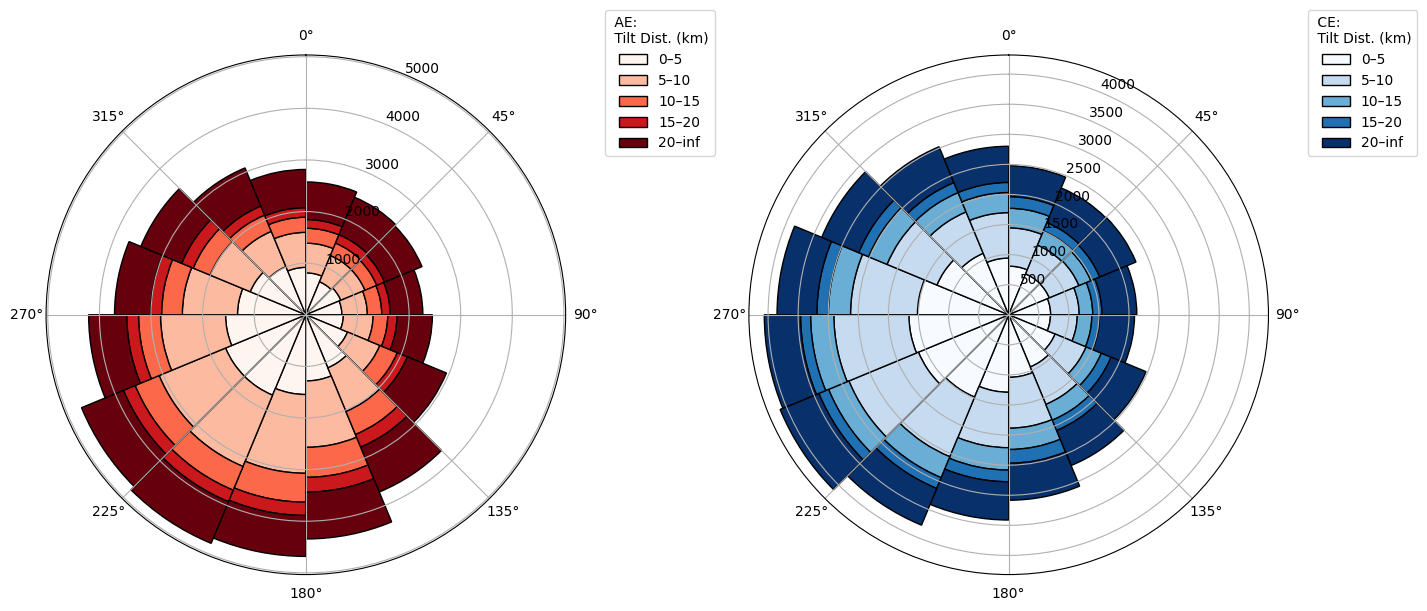

In [12]:
df_AE = df_eddies[df_eddies.Cyc=='AE'].copy()
df_CE = df_eddies[df_eddies.Cyc=='CE'].copy()

# Define your bins once
dir_bins = np.linspace(0, 360, 17)      # 16 sectors
mag_bins = [0, 5, 10, 15, 20, np.inf]     # your strength categories
angles = np.deg2rad((dir_bins[:-1] + dir_bins[1:]) / 2)
width = 2 * np.pi / (len(dir_bins)-1)
colors1 = plt.cm.Reds(np.linspace(0, 1, len(mag_bins)-1))
colors2 = plt.cm.Blues(np.linspace(0, 1, len(mag_bins)-1))

# Create figure + axes
fig, axs = plt.subplots(1, 2,
                        subplot_kw={'projection': 'polar'},
                        figsize=(14, 6),
                        constrained_layout=True)

for a, (ax, (df, title)) in enumerate(zip(axs, [(df_AE, 'AE'), (df_CE, 'CE')])):
    directions = df.prop_bearing_btm
    magnitudes = df.prop_mag_btm

    # Digitise
    dir_idx = np.digitize(directions, dir_bins) - 1
    mag_idx = np.digitize(magnitudes, mag_bins) - 1

    # Count per bin
    counts = np.zeros((len(mag_bins)-1, len(dir_bins)-1))
    for d_i, m_i in zip(dir_idx, mag_idx):
        if 0 <= d_i < counts.shape[1] and 0 <= m_i < counts.shape[0]:
            counts[m_i, d_i] += 1

    # Plot stacked bars
    bottom = np.zeros(counts.shape[1])
    for i in range(counts.shape[0]):
        ax.bar(angles,
               counts[i],
               width,
               bottom=bottom,
               color=colors1[i] if a==0 else colors2[i],
               edgecolor='k',
               label=f'{mag_bins[i]:g}–{mag_bins[i+1]:g}')
        bottom += counts[i]

    ax.set_theta_zero_location('N')
    ax.set_theta_direction(-1)
    # ax.set_title(f'{title}')
    ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1), title=f' {title}: \n Tilt Dist. (km)')

# One legend for both
plt.show()


Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.


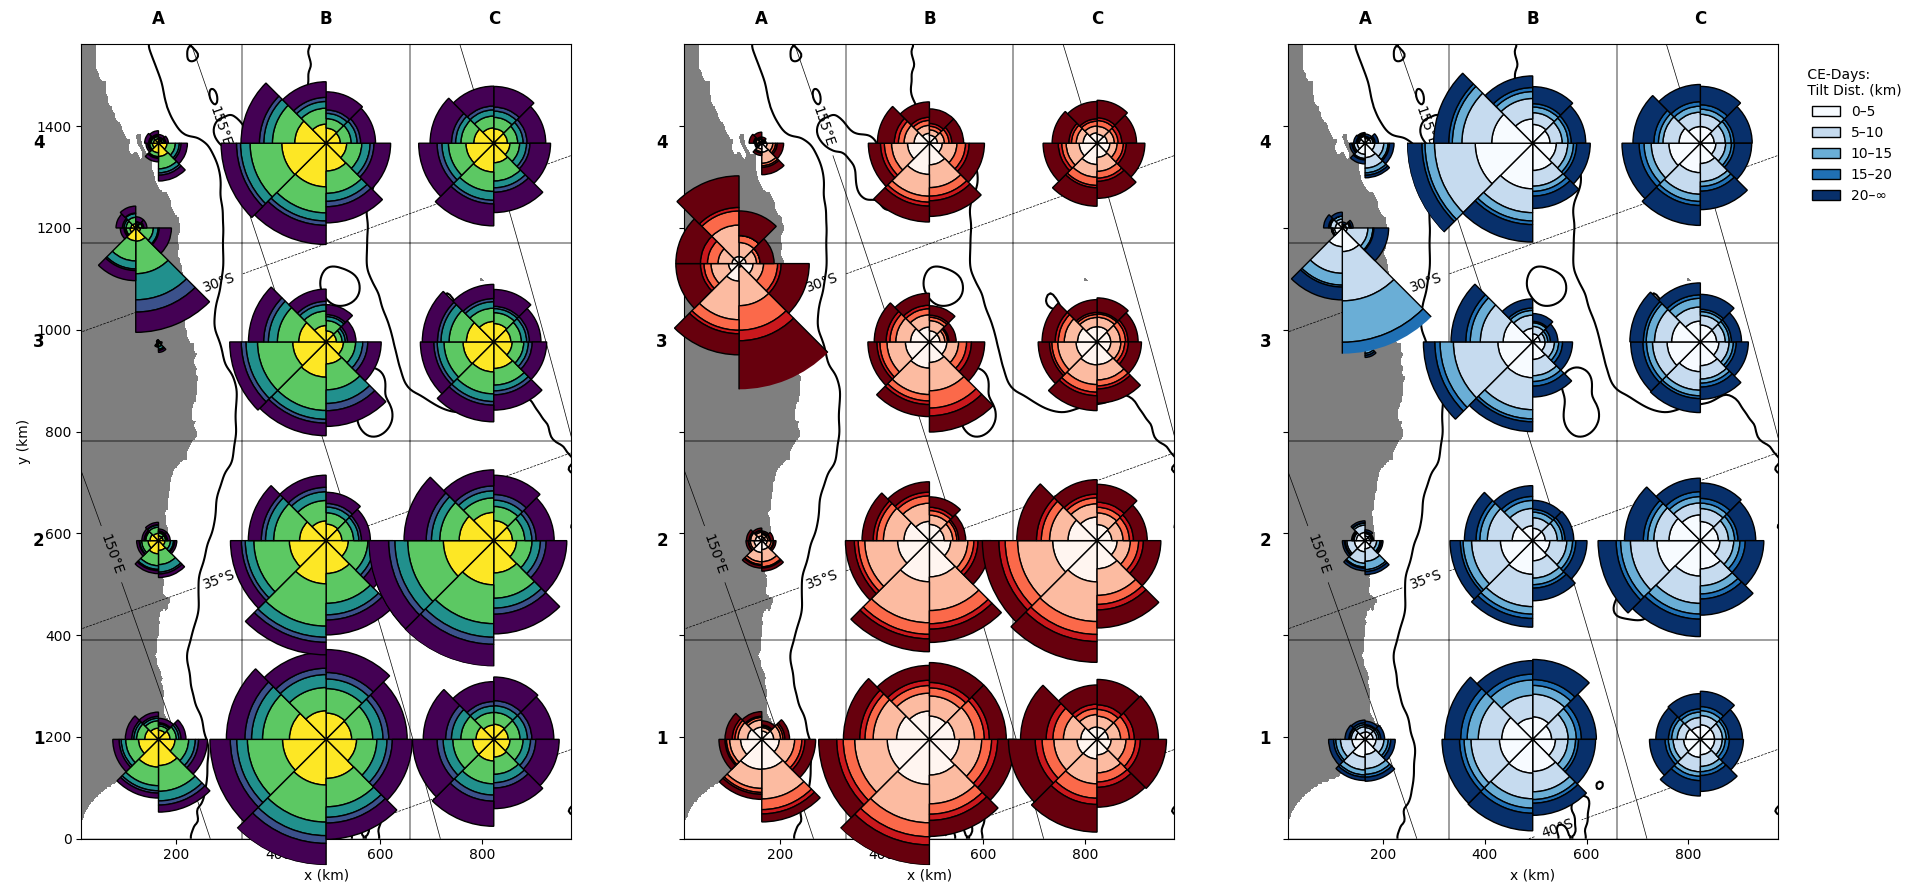

In [13]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

ncols, nrows = 3, 4
x_edges = np.linspace(X_grid.min(), X_grid.max(), ncols+1)
y_edges = np.linspace(Y_grid.min(), Y_grid.max(), nrows+1)
cell_w = (X_grid.max() - X_grid.min())/ncols
cell_h = (Y_grid.max() - Y_grid.min())/nrows

dir_bins = np.linspace(0, 360, 9)
mag_bins = [0, 5, 10, 15, 20, np.inf] 
n_dirs = len(dir_bins) - 1
angles = np.deg2rad((dir_bins[:-1] + dir_bins[1:]) / 2)
width = 2*np.pi / n_dirs
colors_cmps = [plt.cm.viridis_r(np.linspace(0, 1, len(mag_bins)-1)),
               plt.cm.Reds(np.linspace(0, 1, len(mag_bins)-1)),
               plt.cm.Blues(np.linspace(0, 1, len(mag_bins)-1))]

def windrose_counts(directions, magnitudes):
    if len(directions) == 0: return None
    d = np.digitize(np.mod(directions, 360), dir_bins) - 1
    m = np.digitize(magnitudes, mag_bins) - 1
    c = np.zeros((len(mag_bins)-1, n_dirs))
    for di, mi in zip(d, m):
        if 0 <= di < n_dirs and 0 <= mi < len(mag_bins)-1:
            c[mi, di] += 1
    return c

def add_windrose(ax, x0, y0, c, rmax, colors, frac=0.45, tick_flag=False, title=''):
    if c is None: return
    s = frac * min(cell_w, cell_h)
    iax = ax.inset_axes([x0 - s/2, y0 - s/2, s, s], transform=ax.transData, projection='polar')
    bottom = np.zeros(n_dirs)
    for i in range(len(mag_bins)-1):
        hi = "∞" if np.isinf(mag_bins[i+1]) else f"{mag_bins[i+1]:g}"
        label = f"{mag_bins[i]:g}–{hi}"
        iax.bar(angles, c[i], width, bottom=bottom, edgecolor='k', color=colors[i], label=label)
        bottom += c[i]
    iax.set_theta_zero_location('N')
    iax.set_theta_direction(-1)
    iax.set_rlim(0, rmax)
    if tick_flag:
        iax.legend(title=title, loc='upper right', frameon=False, fontsize=10, title_fontsize=10, bbox_to_anchor=(1.35, .85))
    iax.set_xticks([]); iax.set_yticks([]); iax.set_frame_on(False)
    return iax

# precompute counts per cell + global rmax
def cell_counts(df):
    out, rmax = {}, 0.0
    for i in range(ncols):
        for j in range(nrows):
            x0, x1 = x_edges[i], x_edges[i+1]
            y0, y1 = y_edges[j], y_edges[j+1]
            sub = df[(df.xc >= x0) & (df.xc < x1) & (df.yc >= y0) & (df.yc < y1)]
            d = np.asarray((sub.prop_bearing_btm.dropna().values - 20) % 360, float)
            m = np.asarray(sub.prop_mag_btm.dropna().values, float)
            n = min(len(d), len(m))
            c = windrose_counts(d[:n], m[:n])
            out[(i,j)] = c
            if c is not None:
                rmax = max(rmax, np.max(c.sum(axis=0)))
    return out, (1 if rmax == 0 else rmax)

fracs = [1.5, 1.5, 1.5]
fig, axs = plt.subplots(1, 3, figsize=(19, 9), sharey=True)
titles = ['Eddy-Days', 'AE-Days', 'CE-Days']
for p, cyc in enumerate(['AE & CE', 'AE', 'CE']):
    ax = axs[p]
    df = df_eddies if cyc == 'AE & CE' else df_eddies[df_eddies.Cyc == cyc]

    ax.contourf(X_grid, Y_grid, np.where(mask_rho == 0, 1, np.nan), levels=[0.5, 1.5], colors=['k'], alpha=.5)
    c1 = ax.contour(X_grid, Y_grid, lat_rho, levels=levels_lat, colors='k', linewidths=.5)
    ax.clabel(c1, fmt=lambda v: f"{np.abs(v):.0f}°S", inline=True, colors='k')
    c2 = ax.contour(X_grid, Y_grid, lon_rho, levels=levels_lon, colors='k', linewidths=.5)
    ax.clabel(c2, fmt=lambda v: f"{v:.0f}°E", inline=True, colors='k')
    ax.axis('equal'); ax.set_xlim(X_grid.min(), X_grid.max()); ax.set_ylim(Y_grid.min(), Y_grid.max())
    ax.contour(X_grid, Y_grid, h, levels=[4000], colors='k'); #ax.set_title(cyc)

    counts_map, rmax = cell_counts(df)
    for i in range(ncols):
        for j in range(nrows):
            x0, x1 = x_edges[i], x_edges[i+1]
            y0, y1 = y_edges[j], y_edges[j+1]
            xc, yc = 0.5*(x0+x1), 0.5*(y0+y1)
            if (i == 2) and (j==3):
                if p == 2:
                    tick_flag = True
            else:
                tick_flag = False

            add_windrose(ax, xc, yc, counts_map[(i,j)], rmax, colors_cmps[p], frac=fracs[p], tick_flag=tick_flag, title=' ' + titles[p] + ':\n Tilt Dist. (km)')
            if (i==0) and (j==2):
                if p == 1:
                    add_windrose(ax, 120, 1130, counts_map[(i,j)], rmax/40, colors_cmps[p], frac=fracs[p])
                else:
                    add_windrose(ax, 120, 1200, counts_map[(i,j)], rmax/10, colors_cmps[p], frac=fracs[p])
            
            ax.plot([x0, x1, x1, x0, x0], [y0, y0, y1, y1, y0], 'k-', lw=.3)

    # column headers above each column
    col_labels = ['A', 'B', 'C', 'D']
    for i in range(ncols):
        xc = 0.5 * (x_edges[i] + x_edges[i+1])
        ax.text(xc, y_edges[-1] + 0.02*(Y_grid.max()-Y_grid.min()),
                col_labels[i], ha='center', va='bottom', fontsize=12, fontweight='bold')
    
    # row headers to the left of each row (counted from bottom)
    for j in range(nrows):
        yc = 0.5 * (y_edges[j] + y_edges[j+1])
        if p == 0:
            alpha = .06
        else:
            alpha = .02
        ax.text(x_edges[0] - alpha*(X_grid.max()-X_grid.min()), yc,
                f"{j+1}", ha='right', va='center', fontsize=12, fontweight='bold')
            
for ax in axs: ax.set_xlabel('x (km)')
axs[0].set_ylabel('y (km)')
plt.tight_layout(); plt.show()


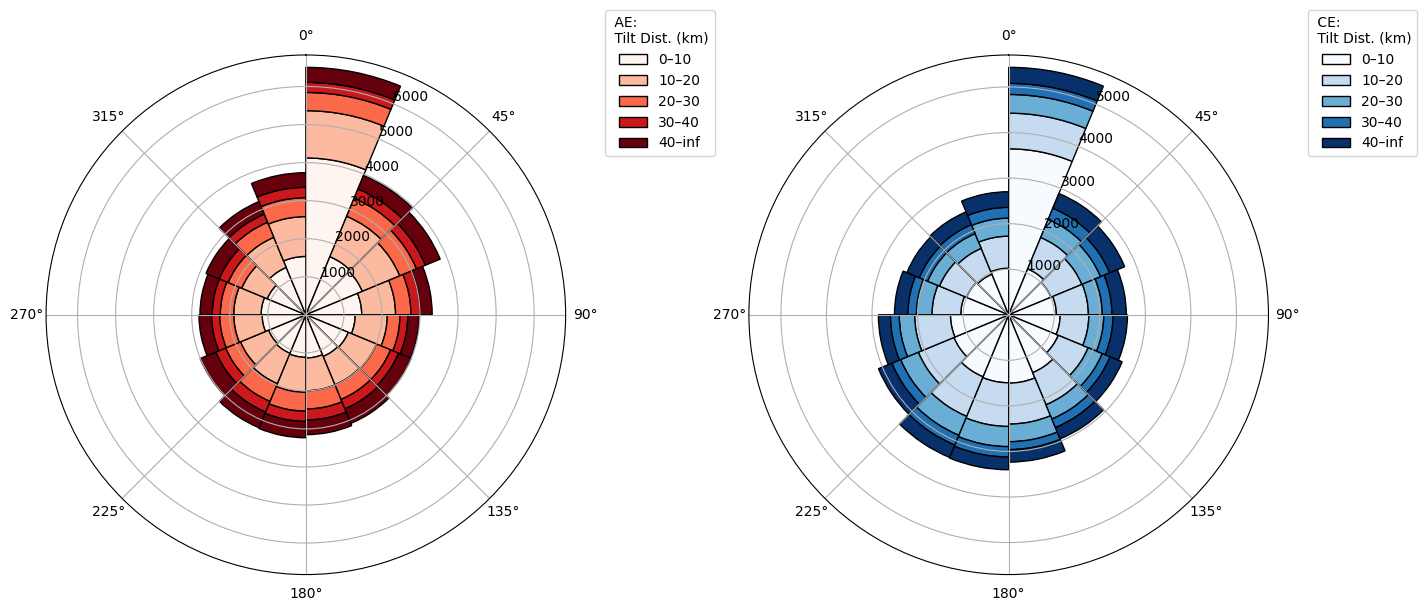

In [14]:
df_AE = df_eddies[df_eddies.Cyc=='AE'].copy()
df_CE = df_eddies[df_eddies.Cyc=='CE'].copy()

# Define your bins once
dir_bins = np.linspace(0, 360, 17)      # 16 sectors
mag_bins = [0, 10, 20, 30, 40, np.inf]     # your strength categories
angles = np.deg2rad((dir_bins[:-1] + dir_bins[1:]) / 2)
width = 2 * np.pi / (len(dir_bins)-1)
colors1 = plt.cm.Reds(np.linspace(0, 1, len(mag_bins)-1))
colors2 = plt.cm.Blues(np.linspace(0, 1, len(mag_bins)-1))

# Create figure + axes
fig, axs = plt.subplots(1, 2,
                        subplot_kw={'projection': 'polar'},
                        figsize=(14, 6),
                        constrained_layout=True)

for a, (ax, (df, title)) in enumerate(zip(axs, [(df_AE, 'AE'), (df_CE, 'CE')])):
    directions = df.prop_bearing_diff
    magnitudes = df.prop_mag_diff

    # Digitise
    dir_idx = np.digitize(directions, dir_bins) - 1
    mag_idx = np.digitize(magnitudes, mag_bins) - 1

    # Count per bin
    counts = np.zeros((len(mag_bins)-1, len(dir_bins)-1))
    for d_i, m_i in zip(dir_idx, mag_idx):
        if 0 <= d_i < counts.shape[1] and 0 <= m_i < counts.shape[0]:
            counts[m_i, d_i] += 1

    # Plot stacked bars
    bottom = np.zeros(counts.shape[1])
    for i in range(counts.shape[0]):
        ax.bar(angles,
               counts[i],
               width,
               bottom=bottom,
               color=colors1[i] if a==0 else colors2[i],
               edgecolor='k',
               label=f'{mag_bins[i]:g}–{mag_bins[i+1]:g}')
        bottom += counts[i]

    ax.set_theta_zero_location('N')
    ax.set_theta_direction(-1)
    # ax.set_title(f'{title}')
    ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1), title=f' {title}: \n Tilt Dist. (km)')

# One legend for both
plt.show()

Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.


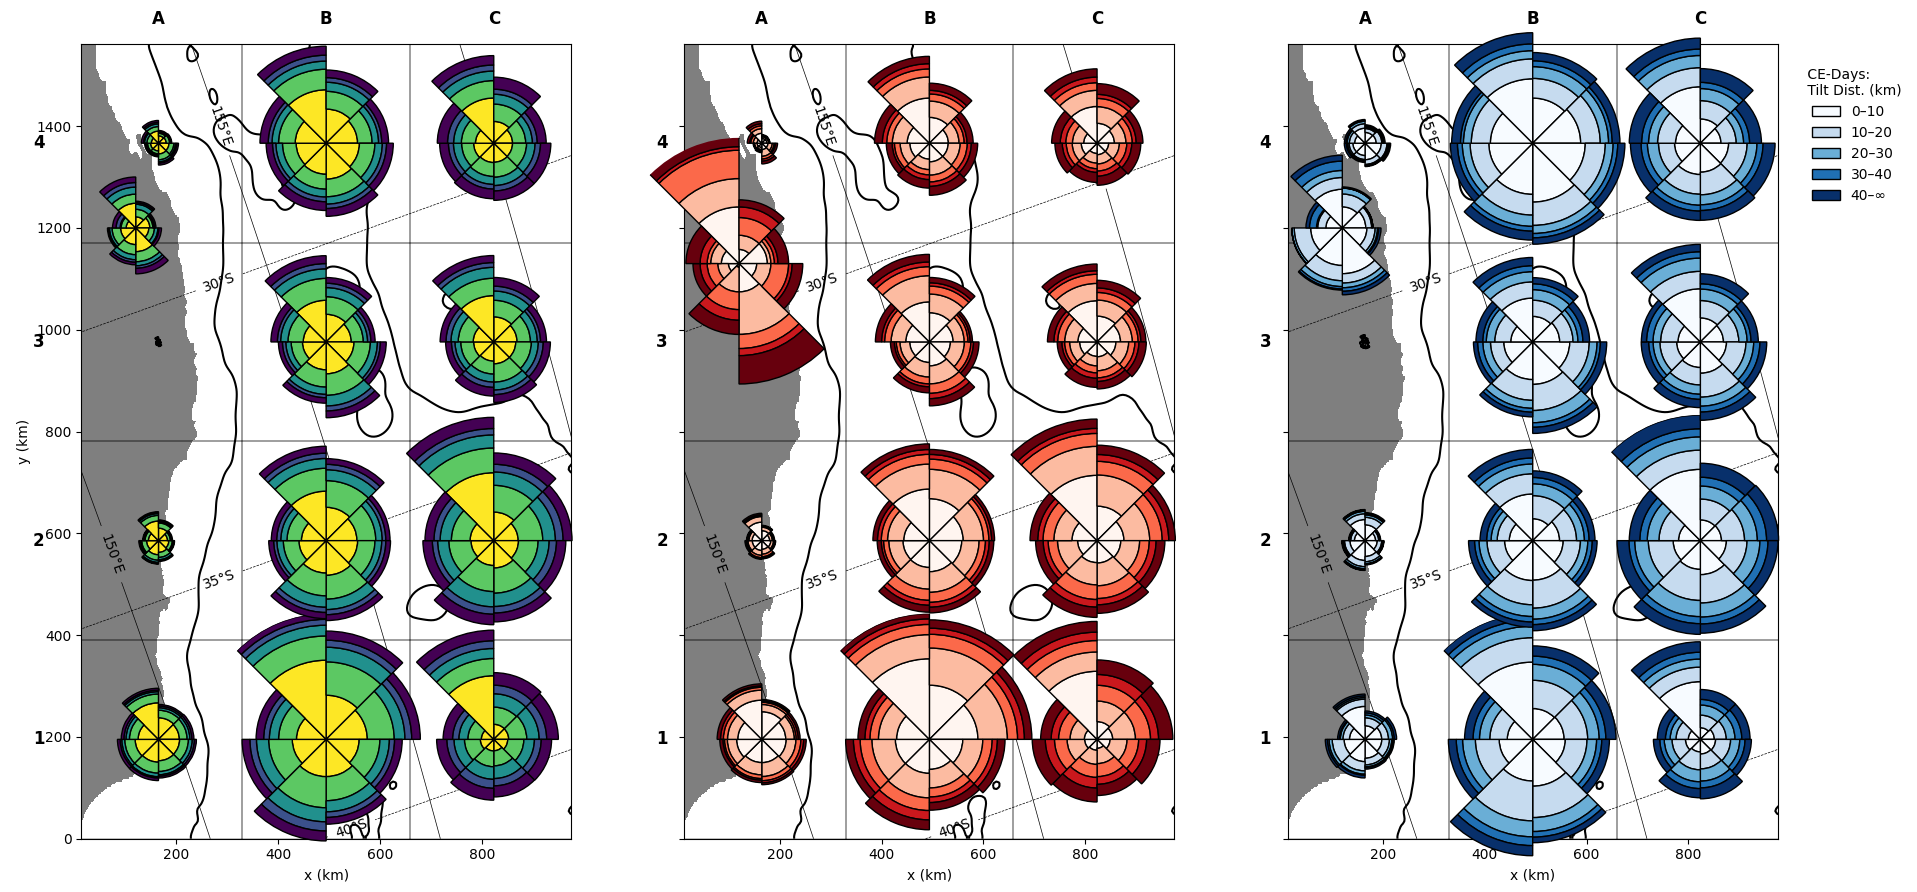

In [15]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

ncols, nrows = 3, 4
x_edges = np.linspace(X_grid.min(), X_grid.max(), ncols+1)
y_edges = np.linspace(Y_grid.min(), Y_grid.max(), nrows+1)
cell_w = (X_grid.max() - X_grid.min())/ncols
cell_h = (Y_grid.max() - Y_grid.min())/nrows

dir_bins = np.linspace(0, 360, 9)
mag_bins = [0, 10, 20, 30, 40, np.inf] 
n_dirs = len(dir_bins) - 1
angles = np.deg2rad((dir_bins[:-1] + dir_bins[1:]) / 2)
width = 2*np.pi / n_dirs
colors_cmps = [plt.cm.viridis_r(np.linspace(0, 1, len(mag_bins)-1)),
               plt.cm.Reds(np.linspace(0, 1, len(mag_bins)-1)),
               plt.cm.Blues(np.linspace(0, 1, len(mag_bins)-1))]

def windrose_counts(directions, magnitudes):
    if len(directions) == 0: return None
    d = np.digitize(np.mod(directions, 360), dir_bins) - 1
    m = np.digitize(magnitudes, mag_bins) - 1
    c = np.zeros((len(mag_bins)-1, n_dirs))
    for di, mi in zip(d, m):
        if 0 <= di < n_dirs and 0 <= mi < len(mag_bins)-1:
            c[mi, di] += 1
    return c

def add_windrose(ax, x0, y0, c, rmax, colors, frac=0.45, tick_flag=False, title=''):
    if c is None: return
    s = frac * min(cell_w, cell_h)
    iax = ax.inset_axes([x0 - s/2, y0 - s/2, s, s], transform=ax.transData, projection='polar')
    bottom = np.zeros(n_dirs)
    for i in range(len(mag_bins)-1):
        hi = "∞" if np.isinf(mag_bins[i+1]) else f"{mag_bins[i+1]:g}"
        label = f"{mag_bins[i]:g}–{hi}"
        iax.bar(angles, c[i], width, bottom=bottom, edgecolor='k', color=colors[i], label=label)
        bottom += c[i]
    iax.set_theta_zero_location('N')
    iax.set_theta_direction(-1)
    iax.set_rlim(0, rmax)
    if tick_flag:
        iax.legend(title=title, loc='upper right', frameon=False, fontsize=10, title_fontsize=10, bbox_to_anchor=(1.35, .85))
    iax.set_xticks([]); iax.set_yticks([]); iax.set_frame_on(False)
    return iax

# precompute counts per cell + global rmax
def cell_counts(df):
    out, rmax = {}, 0.0
    for i in range(ncols):
        for j in range(nrows):
            x0, x1 = x_edges[i], x_edges[i+1]
            y0, y1 = y_edges[j], y_edges[j+1]
            sub = df[(df.xc >= x0) & (df.xc < x1) & (df.yc >= y0) & (df.yc < y1)]
            d = np.asarray((sub.prop_bearing_diff.dropna().values - 20) % 360, float)
            m = np.asarray(sub.prop_mag_diff.dropna().values, float)
            n = min(len(d), len(m))
            c = windrose_counts(d[:n], m[:n])
            out[(i,j)] = c
            if c is not None:
                rmax = max(rmax, np.max(c.sum(axis=0)))
    return out, (1 if rmax == 0 else rmax)

fracs = [1.5, 1.5, 1.5]
fig, axs = plt.subplots(1, 3, figsize=(19, 9), sharey=True)
titles = ['Eddy-Days', 'AE-Days', 'CE-Days']
for p, cyc in enumerate(['AE & CE', 'AE', 'CE']):
    ax = axs[p]
    df = df_eddies if cyc == 'AE & CE' else df_eddies[df_eddies.Cyc == cyc]

    ax.contourf(X_grid, Y_grid, np.where(mask_rho == 0, 1, np.nan), levels=[0.5, 1.5], colors=['k'], alpha=.5)
    c1 = ax.contour(X_grid, Y_grid, lat_rho, levels=levels_lat, colors='k', linewidths=.5)
    ax.clabel(c1, fmt=lambda v: f"{np.abs(v):.0f}°S", inline=True, colors='k')
    c2 = ax.contour(X_grid, Y_grid, lon_rho, levels=levels_lon, colors='k', linewidths=.5)
    ax.clabel(c2, fmt=lambda v: f"{v:.0f}°E", inline=True, colors='k')
    ax.axis('equal'); ax.set_xlim(X_grid.min(), X_grid.max()); ax.set_ylim(Y_grid.min(), Y_grid.max())
    ax.contour(X_grid, Y_grid, h, levels=[4000], colors='k'); #ax.set_title(cyc)

    counts_map, rmax = cell_counts(df)
    for i in range(ncols):
        for j in range(nrows):
            x0, x1 = x_edges[i], x_edges[i+1]
            y0, y1 = y_edges[j], y_edges[j+1]
            xc, yc = 0.5*(x0+x1), 0.5*(y0+y1)
            if (i == 2) and (j==3):
                if p == 2:
                    tick_flag = True
            else:
                tick_flag = False

            add_windrose(ax, xc, yc, counts_map[(i,j)], rmax, colors_cmps[p], frac=fracs[p], tick_flag=tick_flag, title=' ' + titles[p] + ':\n Tilt Dist. (km)')
            if (i==0) and (j==2):
                if p == 1:
                    add_windrose(ax, 120, 1130, counts_map[(i,j)], rmax/40, colors_cmps[p], frac=fracs[p])
                else:
                    add_windrose(ax, 120, 1200, counts_map[(i,j)], rmax/10, colors_cmps[p], frac=fracs[p])
            
            ax.plot([x0, x1, x1, x0, x0], [y0, y0, y1, y1, y0], 'k-', lw=.3)

    # column headers above each column
    col_labels = ['A', 'B', 'C', 'D']
    for i in range(ncols):
        xc = 0.5 * (x_edges[i] + x_edges[i+1])
        ax.text(xc, y_edges[-1] + 0.02*(Y_grid.max()-Y_grid.min()),
                col_labels[i], ha='center', va='bottom', fontsize=12, fontweight='bold')
    
    # row headers to the left of each row (counted from bottom)
    for j in range(nrows):
        yc = 0.5 * (y_edges[j] + y_edges[j+1])
        if p == 0:
            alpha = .06
        else:
            alpha = .02
        ax.text(x_edges[0] - alpha*(X_grid.max()-X_grid.min()), yc,
                f"{j+1}", ha='right', va='center', fontsize=12, fontweight='bold')
            
for ax in axs: ax.set_xlabel('x (km)')
axs[0].set_ylabel('y (km)')
plt.tight_layout(); plt.show()
